#### imports

In [1]:
import os
import re
import joblib
import numpy as np 
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, ReLU, LSTM, Bidirectional, Embedding


#### read data

In [2]:
df = pd.read_csv('../input/flipkart-dataset-final/final_flipkart.csv')

In [3]:
df.head()

,pid,description,category_x,category_y,path,path1
0,SHOEH4GRSUBJGZXE,Key Features of AW Bellies Sandals Wedges Heel...,footwear,Footwear,Footwear/SHOEH4GRSUBJGZXE.jpg,../input/flipkartcomputervisionuploaded/produc...
1,SRTEH2FVVKRBAXHB,Key Features of Alisha Solid Women's Cycling S...,clothing,Clothing,Clothing/SRTEH2FVVKRBAXHB.jpg,../input/flipkartcomputervisionuploaded/produc...
2,SHOEH3DZBFR88SCK,"Key Features of dilli bazaaar Bellies, Corpora...",footwear,Footwear,Footwear/SHOEH3DZBFR88SCK.jpg,../input/flipkartcomputervisionuploaded/produc...
3,SRTEH2FVUHAAVH9X,Key Features of Alisha Solid Women's Cycling S...,clothing,Clothing,Clothing/SRTEH2FVUHAAVH9X.jpg,../input/flipkartcomputervisionuploaded/produc...
4,SHOEH4KM2W3Z6EH5,Key Features of Ladela Bellies Brand: LADELA C...,footwear,Footwear,Footwear/SHOEH4KM2W3Z6EH5.jpg,../input/flipkartcomputervisionuploaded/produc...


#### configuration

In [4]:
seed = 42
maxlen = 100
max_words = 10000
embedding_dim = 100
epochs = 50
batch_size = 64
val_split = 0.2
learning_rate = 1e-4
num_classes = df['category_x'].nunique()
glove_dir = '../input/glove-embeddings'


#### contraction mappings

In [5]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [6]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

#### utils

In [7]:

def expandContractions(text, c_re=c_re):
    
    def replace(match):
        return cList[match.group(0)]
    
    return c_re.sub(replace, text.lower())

def clean_text(row):
    ''' Preprocessing'''
    
    row = row.lower() # converting text to lower case
    
    row = re.sub(r'[^a-z0-9]', ' ', row) # removing special characters, and adding whitespace
    
    row = re.sub(r'[^\w\s\n]', ' ', row) # removing punctuations and newline character, and adding whitespace
                    
    row = expandContractions(row, c_re=c_re)
    
    row = remove_stopwords(row) # removing stopwords using gensim
    
    row = lemmatizer.lemmatize(row, pos='v') # param: pos='v'

    return row
    
def preprocess(data):
    
    data['description'] = data['description'].astype('str')
    data['clean_text'] = data['description'].apply(clean_text)
    description_clean = data['clean_text'].tolist()
    tokenizer.fit_on_texts(description_clean)
    word_index = tokenizer.word_index
    X = tokenizer.texts_to_sequences(description_clean)
    X = pad_sequences(X, maxlen=maxlen)
    return X,word_index
    

def test_text(text):
    
    data = pd.DataFrame({'description':[text]})
    X,word_index = preprocess(data)
    probs = model.predict(X)
    y_pred = encoder.inverse_transform(np.argmax(probs,axis = 1))
    
    return y_pred


def f1_metric_custom(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val


In [8]:
df.head()

,pid,description,category_x,category_y,path,path1
0,SHOEH4GRSUBJGZXE,Key Features of AW Bellies Sandals Wedges Heel...,footwear,Footwear,Footwear/SHOEH4GRSUBJGZXE.jpg,../input/flipkartcomputervisionuploaded/produc...
1,SRTEH2FVVKRBAXHB,Key Features of Alisha Solid Women's Cycling S...,clothing,Clothing,Clothing/SRTEH2FVVKRBAXHB.jpg,../input/flipkartcomputervisionuploaded/produc...
2,SHOEH3DZBFR88SCK,"Key Features of dilli bazaaar Bellies, Corpora...",footwear,Footwear,Footwear/SHOEH3DZBFR88SCK.jpg,../input/flipkartcomputervisionuploaded/produc...
3,SRTEH2FVUHAAVH9X,Key Features of Alisha Solid Women's Cycling S...,clothing,Clothing,Clothing/SRTEH2FVUHAAVH9X.jpg,../input/flipkartcomputervisionuploaded/produc...
4,SHOEH4KM2W3Z6EH5,Key Features of Ladela Bellies Brand: LADELA C...,footwear,Footwear,Footwear/SHOEH4KM2W3Z6EH5.jpg,../input/flipkartcomputervisionuploaded/produc...


#### class distribution

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


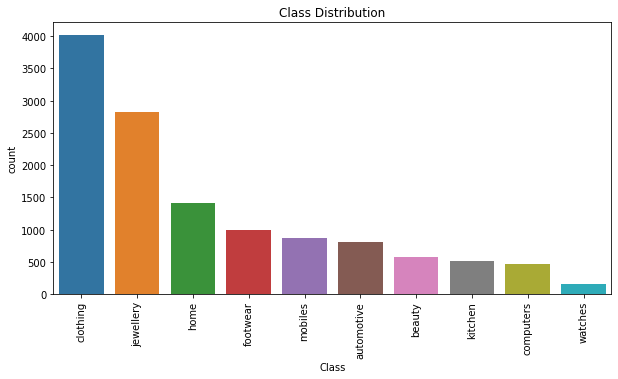

In [9]:
plt.figure(figsize=(10, 5))

sns.countplot(df['category_x'], order=df['category_x'].value_counts().index)

plt.title('Class Distribution')

plt.xlabel('Class')

plt.xticks(rotation=90)

plt.show()

#### lemmatization

In [10]:
lemmatizer = WordNetLemmatizer()
tokenizer = Tokenizer(num_words=max_words)
encoder = LabelEncoder()

In [11]:
X,word_index = preprocess(df)

In [12]:
y = df['category_x'].values.reshape(-1, 1)
y = encoder.fit_transform(y)
y_encoded = to_categorical(y, num_classes=num_classes)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
X.shape, y.shape

((12627, 100), (12627,))

#### glove Embeddings

In [14]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, shuffle=True, random_state=seed)

#### bi-lstm

In [17]:
model = Sequential([
        Embedding(max_words, embedding_dim, weights=[embedding_matrix]),
        Bidirectional(LSTM(512)),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[f1_metric_custom,F1Score(num_classes = num_classes,average='macro')]) 

2022-03-25 12:36:41.447028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 12:36:41.537106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 12:36:41.537885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 12:36:41.539020: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2510848   
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 3,775,818
Trainable params: 3,775,818
Non-trainable params: 0
_________________________________________________________________


In [19]:
checkpoint = ModelCheckpoint('best_model_lstm.hdf5', 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True)

stopping = EarlyStopping(monitor='val_loss', 
                         patience=3, 
                         verbose=1, 
                         restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3,
                              verbose=1,
                              patience=2, 
                              min_lr=1e-6)

In [20]:
model_hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split, callbacks=[checkpoint, stopping, reduce_lr], workers=8)

Epoch 1/50


2022-03-25 12:36:44.520406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-25 12:36:48.160854: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


127/127 [==============================] - 11s 49ms/step - loss: 1.2892 - f1_metric_custom: 0.5035 - f1_score: 0.2916 - val_loss: 0.7140 - val_f1_metric_custom: 0.7337 - val_f1_score: 0.4906

Epoch 00001: val_loss improved from inf to 0.71402, saving model to best_model_lstm.hdf5
Epoch 2/50
127/127 [==============================] - 6s 45ms/step - loss: 0.5426 - f1_metric_custom: 0.8109 - f1_score: 0.6104 - val_loss: 0.3753 - val_f1_metric_custom: 0.8843 - val_f1_score: 0.7277

Epoch 00002: val_loss improved from 0.71402 to 0.37532, saving model to best_model_lstm.hdf5
Epoch 3/50
127/127 [==============================] - 6s 43ms/step - loss: 0.2783 - f1_metric_custom: 0.9183 - f1_score: 0.8395 - val_loss: 0.2332 - val_f1_metric_custom: 0.9276 - val_f1_score: 0.8552

Epoch 00003: val_loss improved from 0.37532 to 0.23315, saving model to best_model_lstm.hdf5
Epoch 4/50
127/127 [==============================] - 6s 44ms/step - loss: 0.1859 - f1_metric_custom: 0.9471 - f1_score: 0.8996 -

In [21]:
model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 12ms/step - loss: 0.0892 - f1_metric_custom: 0.9814 - f1_score: 0.9616


[0.08923918753862381, 0.9813892841339111, 0.9616159200668335]

In [22]:
model.save('lstm_saved_model.hdf5')

#### testing

In [23]:
df['category_x'].unique()

array(['footwear', 'clothing', 'beauty', 'home', 'automotive', 'mobiles',
       'watches', 'jewellery', 'kitchen', 'computers'], dtype=object)

In [24]:
classes = ['footwear', 'clothing', 'beauty', 'home', 'automotive', 'mobiles',
       'watches', 'jewellery', 'kitchen', 'computers']

In [25]:
encoder.classes_

array(['automotive', 'beauty', 'clothing', 'computers', 'footwear',
       'home', 'jewellery', 'kitchen', 'mobiles', 'watches'], dtype=object)

In [26]:
# sample = df['description'][1994]
sample = 'Shining Diva Fashion Latest Stylish Rose Gold Tulip Design Earrings Necklace Jewellery Set For Women (10103s)'
print(test_text(sample))

['jewellery']


In [27]:
for cat in classes:
    print('Category: ',cat)
    for i in df[df['category_x'] == cat].index[:5]:
        sample = df['description'][i]
        print(test_text(sample))


Category:  footwear
['watches']
['footwear']
['footwear']
['beauty']
['beauty']
Category:  clothing
['clothing']
['clothing']
['clothing']
['clothing']
['clothing']
Category:  beauty
['beauty']
['beauty']
['computers']
['beauty']
['mobiles']
Category:  home
['home']
['watches']
['home']
['home']
['home']
Category:  automotive
['beauty']
['computers']
['watches']
['automotive']
['watches']
Category:  mobiles
['jewellery']
['watches']
['automotive']
['mobiles']
['footwear']
Category:  watches
['beauty']
['clothing']
['clothing']
['watches']
['watches']
Category:  jewellery
['jewellery']
['jewellery']
['jewellery']
['footwear']
['beauty']
Category:  kitchen
['clothing']
['watches']
['clothing']
['watches']
['footwear']
Category:  computers
['clothing']
['computers']
['computers']
['clothing']
['mobiles']
